In [56]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/balajivijayaraj/Library/Python/3.10/lib/python/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['source']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from scipy.stats import entropy
import copy
import math
import os
import numpy as np
import matplotlib.pyplot as plt


In [58]:
def getTrainingData(songStrings, nrOfSongs):
    notes = list("ABCDEFGHIJ")
    chord = [[0], [1], [2], [3], [4], [5], [6], [7],[8], [9]]
    source = []
    target = []
    for s in range(nrOfSongs):
        for i in range(42):
            sentence = []
            answer = []
            for j in range(4):
                sentence.append(chord[notes.index(songStrings[s][(i+j)%42])][0])
                answer.append(chord[notes.index(songStrings[s][(i+j+1)%42])][0])
            source.append(sentence)
            target.append(answer)
    return np.array(source), np.array(target)

## Model

In [59]:
class TransformerModel(nn.Module):
    def __init__(self, ntokens, emsize, nhead, d_hid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(emsize, dropout)
        encoder_layers = nn.TransformerEncoderLayer(emsize, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntokens, emsize)
        self.emsize = emsize
        self.decoder = nn.Linear(emsize, ntokens)
        self.ntokens=ntokens
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src,verbose=False):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.emsize)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        self.store=output.detach().numpy().copy()
        if verbose:
            print(output.shape)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Parameters
ntokens = 8  # size of vocabulary
emsize = 20  # embedding dimension
nhead = 4  # number of heads in the nn.MultiheadAttention
d_hid = 20  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer
dropout = 0.03  # dropout probability

# Initialize the model
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
print(model)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
        )
        (linear1): Linear(in_features=20, out_features=20, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=20, out_features=20, bias=True)
        (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
        (dropout2): Dropout(p=0.03, inplace=False)
      )
    )
  )
  (encoder): Embedding(8, 20)
  (decoder): Linear(in_features=20, out_features=8, bias=True)
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Train and evaluate function

In [60]:
import torch.nn.functional as F

def train_and_evaluate(model, source, target, num_epochs, accuracy_thresholds):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    accuracy_epochs = {acc: None for acc in accuracy_thresholds}

    source_tensor = torch.tensor(source, dtype=torch.long)
    target_tensor = torch.tensor(target, dtype=torch.long)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        src = source_tensor.transpose(0, 1)
        tgt = target_tensor.transpose(0, 1)

        output = model(src)
        loss = criterion(output.view(-1, model.ntokens), tgt.reshape(-1))
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            output_prob = F.softmax(output, dim=2)  # Softmax over the class dimension
            target_one_hot = F.one_hot(tgt, num_classes=ntokens).float()  # One-hot encode the target
            
            mse = F.mse_loss(output_prob, target_one_hot)  # Calculate MSE between probabilities and one-hot targets
            predictions = output.argmax(dim=2)
            correct = (predictions == tgt).sum()
            total = tgt.numel()
            accuracy = correct.float() / total

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, MSE: {mse.item():.4f}, Accuracy: {accuracy.item():.4f}')

            for acc in accuracy_thresholds:
                if accuracy >= acc and accuracy_epochs[acc] is None:
                    accuracy_epochs[acc] = epoch
                    if all(accuracy_epochs.values()):
                        break  # Break early if all thresholds are met

    return accuracy_epochs, mse.item()


## Medium parameters - 8,8,2 - Song Complexity

In [69]:

# Parameters
ntokens = 10
emsize = 8
nhead = 2
d_hid = 8
nlayers = 2
dropout = 0.03
learning_rate = 1e-3
num_epochs = 2000
accuracy_thresholds = [0.80,0.90]

# Load the song strings
songStrings = np.array([
    "ABCDEFGHIJABCDEFGHIJABCDEFGHIJABCDEFGHIJAB", # normal
    "JIHGFEDCBAJIHGFEDCBAJIHGFEDCBAJIHGFEDCBAJI", # reverse
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC", # daisybells
    "ABCDEFGHIEABCDEFGHIEABCDEFGHIEABCDEFGHIEAB", # 10th note E
    "ABCDAFGHIJBCDEAGHIAFCDEFIHIABADEFGCIABCBEF", # 5th note different random
    "ABCDAFGHIAABCDAFGHIAABCDAFGHIAABCDAFGHIAAB" # 5th note different
    #"ABCDAFGHIABCDAFGHIABCDAFGHIABCDAFGHIABCDAF" # 5th note A
    #"AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED", # every 2nd note different
])

song_performance_medium = []

for song in songStrings:
    source, target = getTrainingData(np.array([song]), 1)
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
    epochs_to_accuracy, mse = train_and_evaluate(model, source, target, num_epochs, accuracy_thresholds)
    song_performance_medium.append({
        'song': song,
        'epochs_to_accuracy': epochs_to_accuracy,
        'mse': mse
    })

for performance in song_performance_medium:
    print(f"Song: {performance['song']}")
    for acc, epoch in performance['epochs_to_accuracy'].items():
        print(f"  Accuracy {acc*100}% reached at epoch: {epoch if epoch is not None else 'Not reached'}")
    print(f"  MSE: {performance['mse']}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Loss: 2.3186, MSE: 0.0903, Accuracy: 0.1012
Epoch 100, Loss: 1.5131, MSE: 0.0686, Accuracy: 0.8750
Epoch 200, Loss: 0.7815, MSE: 0.0347, Accuracy: 0.9405
Epoch 300, Loss: 0.3859, MSE: 0.0136, Accuracy: 0.9702
Epoch 400, Loss: 0.2309, MSE: 0.0074, Accuracy: 0.9702
Epoch 500, Loss: 0.1580, MSE: 0.0051, Accuracy: 0.9762
Epoch 600, Loss: 0.1229, MSE: 0.0044, Accuracy: 0.9762
Epoch 700, Loss: 0.1104, MSE: 0.0044, Accuracy: 0.9762
Epoch 800, Loss: 0.0902, MSE: 0.0039, Accuracy: 0.9762
Epoch 900, Loss: 0.0838, MSE: 0.0038, Accuracy: 0.9762
Epoch 1000, Loss: 0.0908, MSE: 0.0044, Accuracy: 0.9702
Epoch 1100, Loss: 0.0734, MSE: 0.0038, Accuracy: 0.9762
Epoch 1200, Loss: 0.0695, MSE: 0.0037, Accuracy: 0.9762
Epoch 1300, Loss: 0.0685, MSE: 0.0036, Accuracy: 0.9762
Epoch 1400, Loss: 0.0640, MSE: 0.0035, Accuracy: 0.9762
Epoch 1500, Loss: 0.0690, MSE: 0.0039, Accuracy: 0.9762
Epoch 1600, Loss: 0.0738, MSE: 0.0042, Accuracy: 0.9762
Epoch 1700, Loss: 0.0635, MSE: 0.0036, Accuracy: 0.9762
Epoc

<Figure size 1000x500 with 0 Axes>

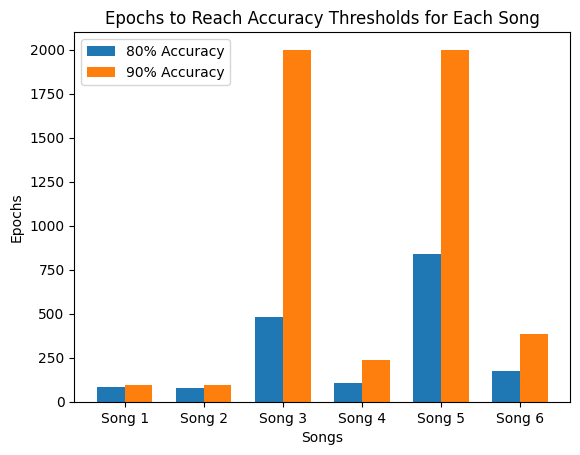

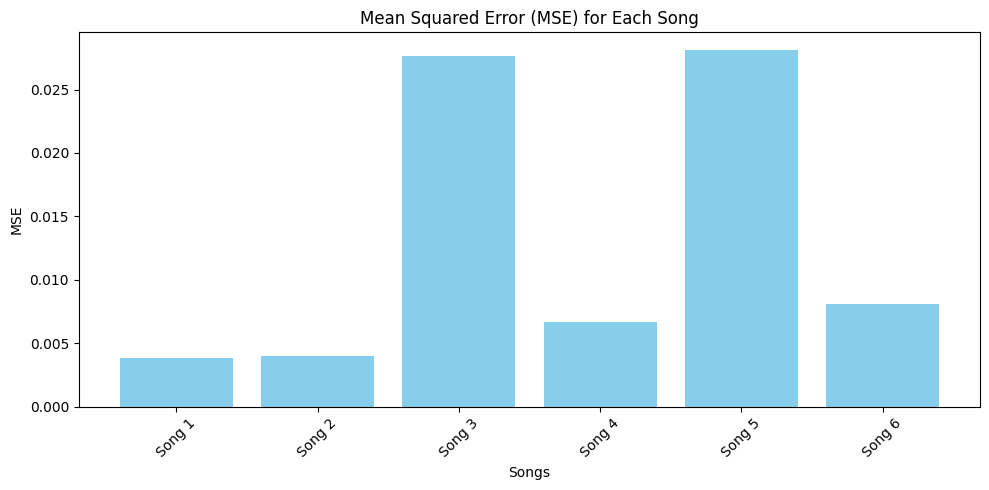

In [70]:
import matplotlib.pyplot as plt

# Assuming 'song_performance' already has the relevant data
# Prepare data for plotting
epochs_data_80_medium = []
epochs_data_90_medium = []
mse_data = []
song_labels = []

for i, performance in enumerate(song_performance_medium):
    song_labels.append(f"Song {i+1}")  # Label songs sequentially
    epochs_data_80_medium.append(performance['epochs_to_accuracy'][0.80] if performance['epochs_to_accuracy'][0.80] is not None else num_epochs)
    epochs_data_90_medium.append(performance['epochs_to_accuracy'][0.90] if performance['epochs_to_accuracy'][0.90] is not None else num_epochs)
    mse_data.append(performance['mse'])

# Plotting the epochs at which each accuracy threshold was reached
plt.figure(figsize=(10, 5))
x = range(len(song_labels))  # x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, epochs_data_80_medium, width, label='80% Accuracy')
rects2 = ax.bar([p + width for p in x], epochs_data_90_medium, width, label='90% Accuracy')

ax.set_xlabel('Songs')
ax.set_ylabel('Epochs')
ax.set_title('Epochs to Reach Accuracy Thresholds for Each Song')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(song_labels)
ax.legend()

plt.show()

# Plotting the MSE for each song
plt.figure(figsize=(10, 5))
plt.bar(song_labels, mse_data, color='skyblue')
plt.title('Mean Squared Error (MSE) for Each Song')
plt.xlabel('Songs')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


    # "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF", # normal
    # "IHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFED", # reverse
    # "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC", # daisybells
    # "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF", # igh contradiction
    # "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF", # 5th note different 
    # "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED", # every 2nd note different

## Large parameters - 16,16,4

In [71]:

# Parameters
ntokens = 10
emsize = 16
nhead = 2
d_hid = 16
nlayers = 4
dropout = 0.03
learning_rate = 1e-3
num_epochs = 2000
accuracy_thresholds = [0.80,0.90]

# Load the song strings
songStrings = np.array([
    "ABCDEFGHIJABCDEFGHIJABCDEFGHIJABCDEFGHIJAB", # normal
    "JIHGFEDCBAJIHGFEDCBAJIHGFEDCBAJIHGFEDCBAJI", # reverse
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC", # daisybells
    "ABCDEFGHIEABCDEFGHIEABCDEFGHIEABCDEFGHIEAB", # 10th note E
    "ABCDAFGHIJBCDEAGHIAFCDEFIHIABADEFGCIABCBEF", # 5th note different random
    "ABCDAFGHIAABCDAFGHIAABCDAFGHIAABCDAFGHIAAB" # 5th note different
    #"AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED", # every 2nd note different
])

song_performance_large = []

for song in songStrings:
    source, target = getTrainingData(np.array([song]), 1)
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
    epochs_to_accuracy, mse = train_and_evaluate(model, source, target, num_epochs, accuracy_thresholds)
    song_performance_large.append({
        'song': song,
        'epochs_to_accuracy': epochs_to_accuracy,
        'mse': mse
    })

for performance in song_performance_large:
    print(f"Song: {performance['song']}")
    for acc, epoch in performance['epochs_to_accuracy'].items():
        print(f"  Accuracy {acc*100}% reached at epoch: {epoch if epoch is not None else 'Not reached'}")
    print(f"  MSE: {performance['mse']}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Loss: 2.3244, MSE: 0.0904, Accuracy: 0.1250


Epoch 100, Loss: 0.7406, MSE: 0.0321, Accuracy: 0.9524
Epoch 200, Loss: 0.2282, MSE: 0.0066, Accuracy: 0.9762
Epoch 300, Loss: 0.1259, MSE: 0.0042, Accuracy: 0.9762
Epoch 400, Loss: 0.0952, MSE: 0.0038, Accuracy: 0.9762
Epoch 500, Loss: 0.0831, MSE: 0.0039, Accuracy: 0.9762
Epoch 600, Loss: 0.0762, MSE: 0.0039, Accuracy: 0.9762
Epoch 700, Loss: 0.0695, MSE: 0.0036, Accuracy: 0.9762
Epoch 800, Loss: 0.0689, MSE: 0.0039, Accuracy: 0.9702
Epoch 900, Loss: 0.0672, MSE: 0.0040, Accuracy: 0.9762
Epoch 1000, Loss: 0.0648, MSE: 0.0038, Accuracy: 0.9762
Epoch 1100, Loss: 0.0636, MSE: 0.0038, Accuracy: 0.9762
Epoch 1200, Loss: 0.0612, MSE: 0.0037, Accuracy: 0.9762
Epoch 1300, Loss: 0.0572, MSE: 0.0035, Accuracy: 0.9762
Epoch 1400, Loss: 0.0638, MSE: 0.0040, Accuracy: 0.9762
Epoch 1500, Loss: 0.0603, MSE: 0.0038, Accuracy: 0.9762
Epoch 1600, Loss: 0.0597, MSE: 0.0037, Accuracy: 0.9762
Epoch 1700, Loss: 0.0593, MSE: 0.0037, Accuracy: 0.9762
Epoch 1800, Loss: 0.0592, MSE: 0.0037, Accuracy: 0.9762
E

<Figure size 1000x500 with 0 Axes>

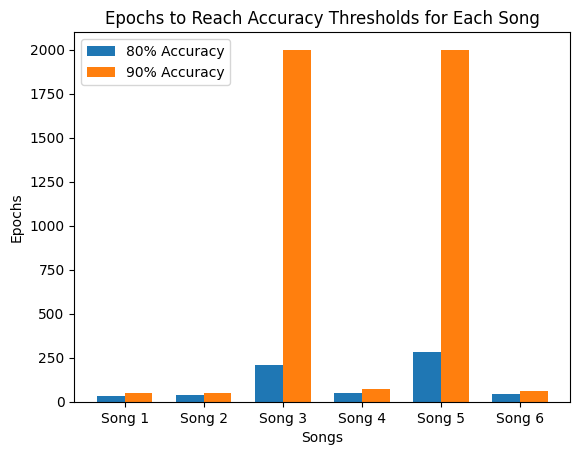

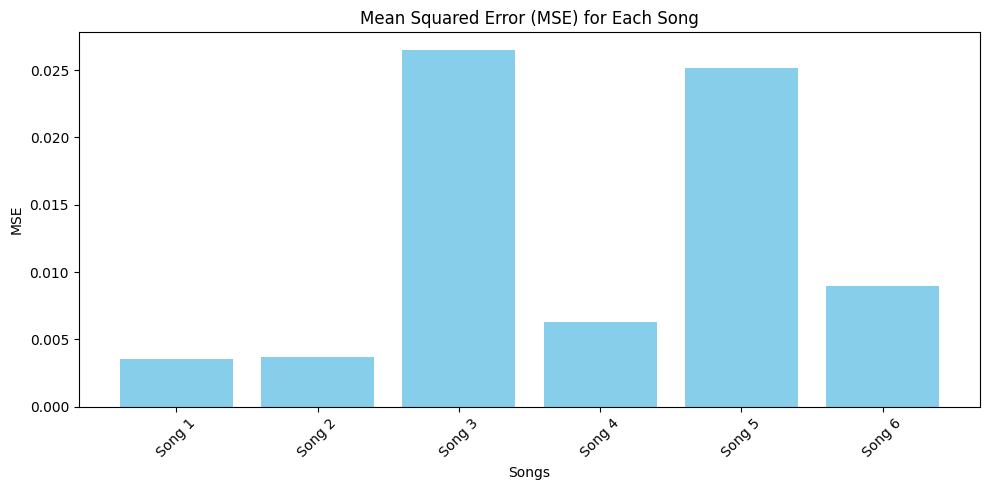

In [72]:
import matplotlib.pyplot as plt

# Assuming 'song_performance' already has the relevant data
# Prepare data for plotting
epochs_data_80_large = []
epochs_data_90_large = []
mse_data = []
song_labels = []

for i, performance in enumerate(song_performance_large):
    song_labels.append(f"Song {i+1}")  # Label songs sequentially
    epochs_data_80_large.append(performance['epochs_to_accuracy'][0.80] if performance['epochs_to_accuracy'][0.80] is not None else num_epochs)
    epochs_data_90_large.append(performance['epochs_to_accuracy'][0.90] if performance['epochs_to_accuracy'][0.90] is not None else num_epochs)
    mse_data.append(performance['mse'])

# Plotting the epochs at which each accuracy threshold was reached
plt.figure(figsize=(10, 5))
x = range(len(song_labels))  # x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, epochs_data_80_large, width, label='80% Accuracy')
rects2 = ax.bar([p + width for p in x], epochs_data_90_large, width, label='90% Accuracy')

ax.set_xlabel('Songs')
ax.set_ylabel('Epochs')
ax.set_title('Epochs to Reach Accuracy Thresholds for Each Song')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(song_labels)
ax.legend()

plt.show()

# Plotting the MSE for each song
plt.figure(figsize=(10, 5))
plt.bar(song_labels, mse_data, color='skyblue')
plt.title('Mean Squared Error (MSE) for Each Song')
plt.xlabel('Songs')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


    # "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF", # normal
    # "IHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFED", # reverse
    # "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC", # daisybells
    # "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF", # igh contradiction
    # "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF", # 5th note different 
    # "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED", # every 2nd note different

## small parameters - 16,16,4

In [73]:

# Parameters
ntokens = 10
emsize = 4
nhead = 2
d_hid = 4
nlayers = 1
dropout = 0.03
learning_rate = 1e-3
num_epochs = 2000
accuracy_thresholds = [0.80,0.90]

# Load the song strings
songStrings = np.array([
   "ABCDEFGHIJABCDEFGHIJABCDEFGHIJABCDEFGHIJAB", # normal
    "JIHGFEDCBAJIHGFEDCBAJIHGFEDCBAJIHGFEDCBAJI", # reverse
    "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC", # daisybells
    "ABCDEFGHIEABCDEFGHIEABCDEFGHIEABCDEFGHIEAB", # 10th note E
    "ABCDAFGHIJBCDEAGHIAFCDEFIHIABADEFGCIABCBEF", # random
    "ABCDAFGHIAABCDAFGHIAABCDAFGHIAABCDAFGHIAAB" # 5th note different
    #"AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED", # every 2nd note different
])

song_performance_small = []

for song in songStrings:
    source, target = getTrainingData(np.array([song]), 1)
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout)
    epochs_to_accuracy, mse = train_and_evaluate(model, source, target, num_epochs, accuracy_thresholds)
    song_performance_small.append({
        'song': song,
        'epochs_to_accuracy': epochs_to_accuracy,
        'mse': mse
    })

for performance in song_performance_small:
    print(f"Song: {performance['song']}")
    for acc, epoch in performance['epochs_to_accuracy'].items():
        print(f"  Accuracy {acc*100}% reached at epoch: {epoch if epoch is not None else 'Not reached'}")
    print(f"  MSE: {performance['mse']}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Loss: 2.3124, MSE: 0.0902, Accuracy: 0.0655
Epoch 100, Loss: 2.0444, MSE: 0.0848, Accuracy: 0.2440
Epoch 200, Loss: 1.5710, MSE: 0.0730, Accuracy: 0.4881
Epoch 300, Loss: 1.2578, MSE: 0.0604, Accuracy: 0.6488
Epoch 400, Loss: 1.0126, MSE: 0.0498, Accuracy: 0.7500
Epoch 500, Loss: 0.7443, MSE: 0.0370, Accuracy: 0.8750
Epoch 600, Loss: 0.5634, MSE: 0.0265, Accuracy: 0.9048
Epoch 700, Loss: 0.4517, MSE: 0.0198, Accuracy: 0.9405
Epoch 800, Loss: 0.3725, MSE: 0.0151, Accuracy: 0.9405
Epoch 900, Loss: 0.2965, MSE: 0.0122, Accuracy: 0.9524
Epoch 1000, Loss: 0.2710, MSE: 0.0115, Accuracy: 0.9345
Epoch 1100, Loss: 0.1962, MSE: 0.0073, Accuracy: 0.9643
Epoch 1200, Loss: 0.1749, MSE: 0.0068, Accuracy: 0.9643
Epoch 1300, Loss: 0.1480, MSE: 0.0054, Accuracy: 0.9702
Epoch 1400, Loss: 0.1630, MSE: 0.0069, Accuracy: 0.9583
Epoch 1500, Loss: 0.1597, MSE: 0.0070, Accuracy: 0.9524
Epoch 1600, Loss: 0.1306, MSE: 0.0061, Accuracy: 0.9583
Epoch 1700, Loss: 0.1283, MSE: 0.0058, Accuracy: 0.9643
Epoc

<Figure size 1000x500 with 0 Axes>

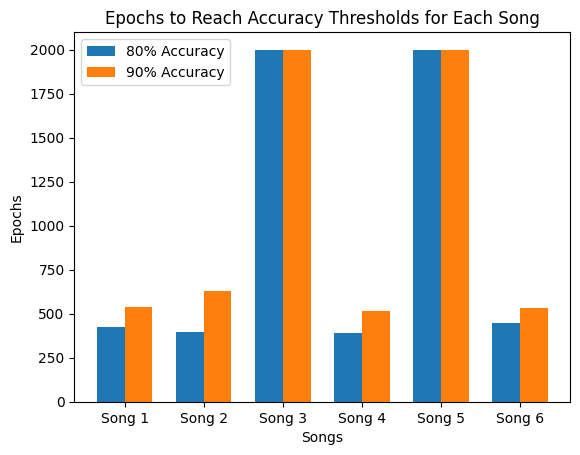

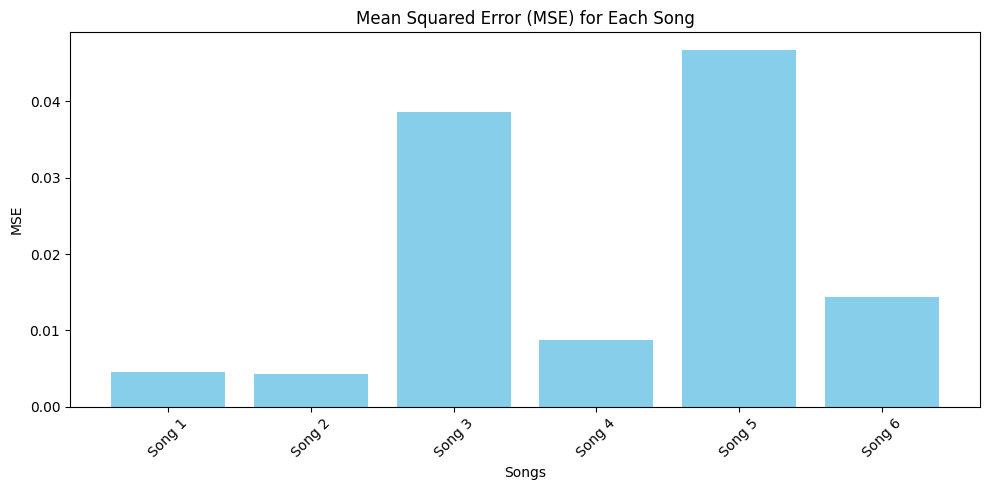

In [74]:
import matplotlib.pyplot as plt

# Assuming 'song_performance' already has the relevant data
# Prepare data for plotting
epochs_data_80_small = []
epochs_data_90_small = []
mse_data = []
song_labels = []

for i, performance in enumerate(song_performance_small):
    song_labels.append(f"Song {i+1}")  # Label songs sequentially
    epochs_data_80_small.append(performance['epochs_to_accuracy'][0.80] if performance['epochs_to_accuracy'][0.80] is not None else num_epochs)
    epochs_data_90_small.append(performance['epochs_to_accuracy'][0.90] if performance['epochs_to_accuracy'][0.90] is not None else num_epochs)
    mse_data.append(performance['mse'])

# Plotting the epochs at which each accuracy threshold was reached
plt.figure(figsize=(10, 5))
x = range(len(song_labels))  # x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, epochs_data_80_small, width, label='80% Accuracy')
rects2 = ax.bar([p + width for p in x], epochs_data_90_small, width, label='90% Accuracy')

ax.set_xlabel('Songs')
ax.set_ylabel('Epochs')
ax.set_title('Epochs to Reach Accuracy Thresholds for Each Song')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(song_labels)
ax.legend()

plt.show()

# Plotting the MSE for each song
plt.figure(figsize=(10, 5))
plt.bar(song_labels, mse_data, color='skyblue')
plt.title('Mean Squared Error (MSE) for Each Song')
plt.xlabel('Songs')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


    # "ABCDEFGHIABCDEFGHIABCDEFGHIABCDEFGHIABCDEF", # normal
    # "IHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFEDCBAIHGFED", # reverse
    # "CCGGAAGFFEEDDCGGFFEEDGGFFEEDCCGGAAGFFEEDDC", # daisybells
    # "ABCDEFIGHABCDEFIGHABCDEFIGHABCDEFIGHABCDEF", # igh contradiction
    # "ABCDAFGHIEBCDEAGHIAFCDEFIHIABADEFGCIABCBEF", # 5th note different 
    # "AHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFEDGBIAHCFED", # every 2nd note different

## Model Size

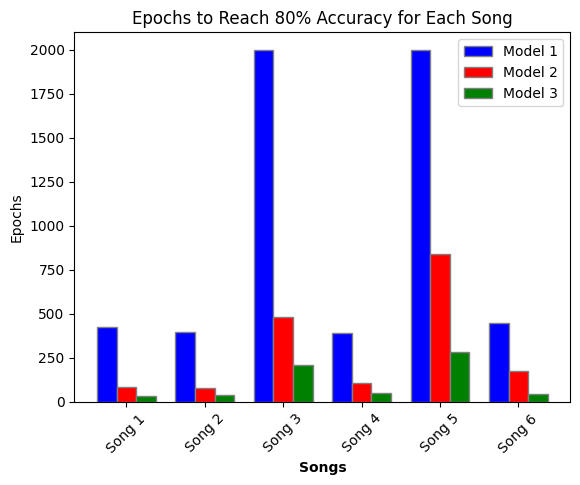

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Define the song titles for display on the plot
song_titles = [
    "Song 1",
    "Song 2",
    "Song 3",
    "Song 4",
    "Song 5",
    "Song 6"
]


# Plotting the data
fig, ax = plt.subplots()

# Set position of bar on X axis
bar_width = 0.25  # Narrower bar width to fit three bars
r1 = np.arange(len(song_titles))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
ax.bar(r1, epochs_data_80_small, color='b', width=bar_width, edgecolor='grey', label='Model 1')
ax.bar(r2, epochs_data_80_medium, color='r', width=bar_width, edgecolor='grey', label='Model 2')
ax.bar(r3, epochs_data_80_large, color='g', width=bar_width, edgecolor='grey', label='Model 3')

# Add xticks on the middle of the group bars
ax.set_xlabel('Songs', fontweight='bold')
ax.set_xticks([r + bar_width for r in r1])
ax.set_xticklabels(song_titles)

# Create legend & Show graphic
ax.legend()
plt.xticks(rotation=45)
plt.title('Epochs to Reach 80% Accuracy for Each Song')
plt.ylabel('Epochs')
plt.show()
